In [22]:
import data
import models
import cache
import seaborn as sns
import numpy as np
import pandas as pd
import patsy
from matplotlib import pyplot as plt

In [23]:
sns.set(context='talk')

In [24]:
model_name = 'model5.1'
by = 'SubSet'
sample_n = 500

## load files for all cell types

In [25]:
df = cache.cached(data.prep_annotated_data)

INFO:stancache.stancache:prep_annotated_data: cache_filename set to prep_annotated_data.cached.default.pkl
INFO:stancache.stancache:prep_annotated_data: Loading result from cache


In [26]:
assert all(pd.notnull(df['log1p_tpm_rescaled']))

In [27]:
print(df.columns)

#apply(lambda x: x.startswith('C'))

Index(['sample_id', 'filename', 'gene_name', 'est_counts', 'tpm', 'log1p_tpm',
       'log1p_counts', 'CCR6+', 'CCR7+', 'CCR7-', 'CD127-', 'CD161+', 'CD19+',
       'CD25+', 'CD27+', 'CD27-', 'CD4+', 'CD45RA+', 'CD45RA-', 'CD45RO+',
       'CD45RO-', 'CD5+', 'CD5-', 'CD8+', 'CRTH2+', 'CXCR3+', 'CXCR3-',
       'SubSet', 'cell_type', 'log1p_tpm_rescaled_type',
       'log1p_tpm_rescaled_subset', 'log1p_tpm_rescaled', 'gene_cat',
       'gene_id', 'B_cell', 'T_cell'],
      dtype='object')


## sample genes for analysis

In [28]:
sample_df = cache.cached(models.prep_sample_df, sample_n=sample_n)

INFO:stancache.stancache:prep_sample_df: cache_filename set to prep_sample_df.cached.sample_n_500.pkl
INFO:stancache.stancache:prep_sample_df: Loading result from cache


## fit model

In [29]:
stan_data = models.prep_stan_data(sample_df, by=by)

In [30]:
model_file = models.get_model_file(model_name=model_name)
print(cache._read_file(model_file))

## neg binom parameterization
## estimate correlation matrix among cell types
data {
    // dimensions
    int<lower=1> N;  // N obs
    int<lower=1> G;  // N genes
    int<lower=1> S;  // N samples
    int<lower=0> C;  // N classes (e.g. B-cell, T-cell, B_Naive, CD5, CD45RO, etc)
                     //     note: classes should be mutually exclusive. Each row here should sum to 1
    // int<lower=0> M; // number of cell-level predictors 
   
    // data for each gene*sample
    int<lower=1, upper=G> gene[N];    // gene id for each obs
    int<lower=1, upper=S> sample[N];  // sample id for each obs
    vector<lower=0, upper=1>[C] x[N]; // map each obs to each class (0:'- or ?', 1:'+')
    int<lower=0> y[N];                // count/tpm for each obs
    
    // group-level predictors for each class C
    // (to come) - 
}
transformed data {
    int sample_y[S, G];    // array (size SxG) of ints
    vector[C] sample_x[S]; // array (size S) of vectors[C]
    vector[C] theta_mu;
    for (n 

In [31]:
model_fit = models.cached_stan_fit(file=model_file, data=stan_data, model_name=model_name)

INFO:stancache.stancache:Step 1: Get compiled model code, possibly from cache
INFO:stancache.stancache:StanModel: cache_filename set to model5_1.cython_0_25_1.model_code_65647409730.pystan_2_12_0_0.stanmodel.pkl
INFO:stancache.stancache:StanModel: Loading result from cache
INFO:stancache.stancache:Step 2: Get posterior draws from model, possibly from cache
INFO:stancache.stancache:sampling: cache_filename set to model5_1.cython_0_25_1.model_code_65647409730.pystan_2_12_0_0.stanfit.chains_4.data_64787202190.iter_2000.seed_1245502385.pkl
INFO:stancache.stancache:sampling: Loading result from cache


## check convergence (superficially)

In [32]:
models.print_stan_summary(model_fit, pars='lp__')

              mean    se_mean       sd          2.5%           50%         97.5%      Rhat
lp__  7.978003e+07  97.559869  436.301  7.977928e+07  7.977998e+07  7.978098e+07  1.261306


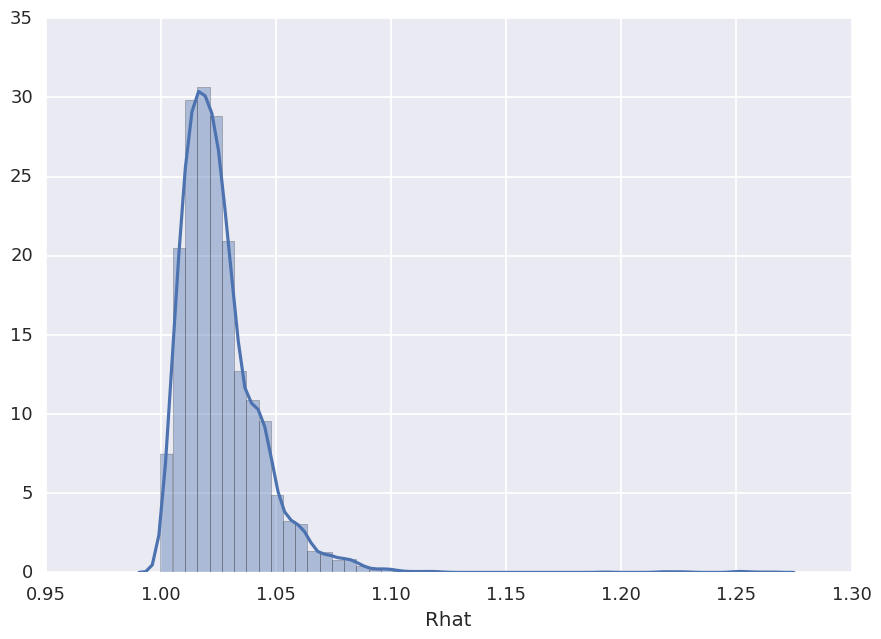

In [33]:
models.plot_stan_summary(model_fit, pars='theta', metric='Rhat')

## summarize posterior draws of theta by gene

In [34]:
# meta-data used for plotting functions below
# so that the following code is invariant to the model run
colnames = list(stan_data['x'].columns)
sort_by = colnames[0]
print(sort_by)

SubSet[B_CD5]


In [35]:
theta_ldf = models.prep_theta_summary(model_fit, sample_df=sample_df, colnames=colnames, expose_group=sort_by)

MemoryError: 

In [ ]:
## show theta estimates for first 50 genes, by `sort-by`
g = sns.boxplot(data=theta_ldf.loc[theta_ldf['mean_value_rank_{}'.format(sort_by)] <= 50,:] \
                .sort_values('mean_value_rank_{}'.format(sort_by)),
            y='new_gene_cat',
            x='value',
            hue='variable', 
            fliersize=0, width=2, linewidth=0.2)

In [ ]:
## zoom in on the highest-ranked genes by `sort-by` difference from average 
## across all cell types
g = sns.boxplot(data=theta_ldf.loc[theta_ldf['mean_abs_diff_rank_{}'.format(sort_by)] <= 10,:] \
                .sort_values('mean_diff_rank_{}'.format(sort_by)),
            y='new_gene_cat',
            x='value',
            hue='variable', 
            fliersize=0, linewidth=0.2)

## posterior-predictive checking for selected genes

In [ ]:
# identify top_genes by name
top_genes = theta_ldf.loc[theta_ldf['mean_abs_diff_rank_{}'.format(sort_by)] <= 10,:] \
                .drop_duplicates(subset='new_gene_cat')['new_gene_cat'].values
print(top_genes)

In [ ]:
# get yrep draws
yrep_df = models.prep_yrep_summary(model_fit, sample_df=sample_df, filter_genes=top_genes)

In [ ]:
models.plot_posterior_predictive_checks(model_fit=model_fit, plot_genes=top_genes, sample_df=sample_df,
                                        yrep_df=yrep_df, n_genes=1)

In [ ]:
models.plot_posterior_predictive_checks(model_fit=model_fit, plot_genes=top_genes[1:], sample_df=sample_df,
                                        yrep_df=yrep_df, n_genes=1)

In [ ]:
models.plot_posterior_predictive_checks(model_fit=model_fit, plot_genes=['BTLA'], sample_df=sample_df,
                                        yrep_df=yrep_df, n_genes=1)

## summarize posterior draws for `theta_mu`

In [ ]:
#mu_ldf = models.prep_theta_mu_summary(stan_fit=model_fit, stan_data=stan_data, par='theta_mu')

In [ ]:
#a = sns.boxplot(data=mu_ldf, x='variable', y='value')
#plt.setp(a.get_xticklabels(), rotation='vertical')

## summarize posterior draws for `Omega`

In [ ]:
omega_summary = models.prep_omega_summary(stan_fit=model_fit, stan_data=stan_data, par='Omega', gene_id=by)

In [ ]:
with sns.plotting_context('paper'):
    sns.heatmap(omega_summary.loc[:, list(stan_data['x'].columns)])